In [1]:
# Jade Chongsathapornpong, June 2023
import os

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

import rocklogparse as rlp

# We'll be using an interactive backend, if we want to interact with plots
#%matplotlib nbagg 
# Otherwise we show them as-is
%matplotlib inline

# Associating spectrum filenames with temperatures

In [2]:
# Modify these
in_dir = r'Output/ROCK_XRD/WAM39B_integrated/rampe1' # directory containing integrated spectra
# log_file = r'../Data/ROCK/WAM39B.txt' # log with temperature columns
xrd_log_file = r'../Data/ROCK/logbook_XRD.txt' # log with file names
temp_cal_file = r'../Data/ROCK/calibration_gas_blower_1mm.txt' # log file with temperature columns for calib

Problem: The XRD images (even in their original NeXus formats!) do not contain timestamps. This would have saved me a lot of time, but instead I am correlating filenames from the XRD logbook.

In [3]:
def key_gen(entry):
    """Takes a metadata entry for the unprocessed data and returns the resulting integrated file's name"""
    logname = os.path.split(entry[0])[-1] # name of the file according to the log
    x0 = logname.lower() # NeXus files were lowercase
    index = x0.find('XRD_') # NeXus files had extra zeros
    x1 = x0[:index - 1] + '000' + x0[index - 1:] + '_integrated' # We added a suffix on azimuthal integration
    return x1

xrd_entries = rlp.separate_entries(xrd_log_file, skiplines=12)
print(xrd_entries[0])
metadata = rlp.extract_logbook_XRD_metadata(xrd_entries)
print("\n", metadata[0])
meta_dict = rlp.create_filename_dictionary(metadata, key_gen)
# print("\n", meta_dict.keys())

['Sat 3 Jun 2023 - 09:34:46', 'XRD/Test_anthony/test', 'Sample position: x=2.9, z=29.92 and phi=-0.0', 'Sample temperature: 18.5 degC when opening the shutter, 18.6 degC when closing the shutter', 'Absolute time: 1685777686.9095669 when opening the shutter, 1685777691.2926607 when closing the shutter', 'Monochromator was at 10999.65 eV']

 ('XRD/Test_anthony/test', 18.5, 18.6, 1685777686.9095669, 1685777691.2926607, 10999.65)


# Calibrating temperatures and reading spectra
Now I'm going to use the calibration file to perform a fit.

Covariances
 [[ 1.16888629e-12 -1.08020955e-09  7.45944282e-08]
 [-1.08020955e-09  1.06155040e-06 -9.05664686e-05]
 [ 7.45944282e-08 -9.05664686e-05  2.07220001e-02]]
Fit: -0.0001761292340057989 T^2 + 1.0543244247291368 T + 0.0033350713710040606


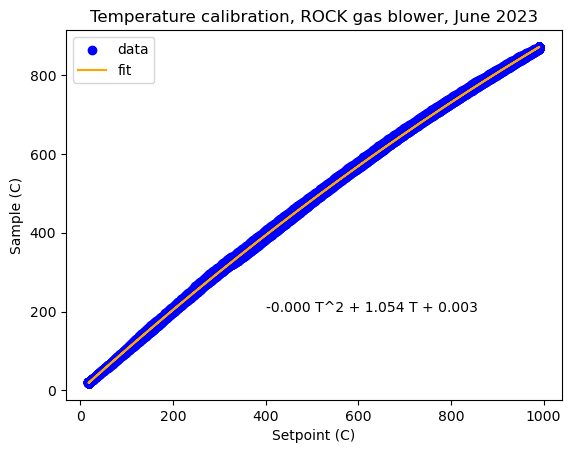

In [4]:
sample_vs_setpt = np.array(rlp.read_column_log(temp_cal_file, indices=(1,3), skiprows=3)).transpose()
sample = sample_vs_setpt[0] # sample temperature, y-axis
setpoint = sample_vs_setpt[1] # control temperature, x-axis

def quadratic(x, a, b, c):
    return a*x*x + b*x + c

poptim, pcovar = curve_fit(quadratic, setpoint, sample)
print("Covariances\n", pcovar)
print(f"Fit: {poptim[0]} T^2 + {poptim[1]} T + {poptim[2]}")

plt.title("Temperature calibration, ROCK gas blower, June 2023")
plt.scatter(setpoint, sample, label='data', color='blue')
plt.plot(setpoint, quadratic(setpoint, poptim[0], poptim[1], poptim[2]), label='fit', color='orange')
plt.xlabel("Setpoint (C)")
plt.ylabel("Sample (C)")
plt.legend()
plt.text(400, 200, f"{poptim[0]:.3f} T^2 + {poptim[1]:.3f} T + {poptim[2]:.3f}")
# plt.savefig("tempcalROCK", dpi=300)
plt.show()

In [12]:
output_data = []

for filename in os.listdir(in_dir):
    # Read the metadata from our dictionary
    key = os.path.splitext(filename)[0] # just the filename, no extension
    meta = meta_dict[key]
    mean_temp = 0.5 * (meta[1] + meta[2])
    corrected_temp = quadratic(mean_temp, poptim[0], poptim[1], poptim[2])
    time = int(meta[3])
    # Read the spectrum from file
    path = os.path.join(in_dir, filename)
    data = np.genfromtxt(path).transpose()
    output_data.append((corrected_temp, data, time))

#output_data.sort(key=lambda x: x[0]) # sort the spectra in order of ascending temperature
print(len(output_data))

39


# Plotting spectra by temperature

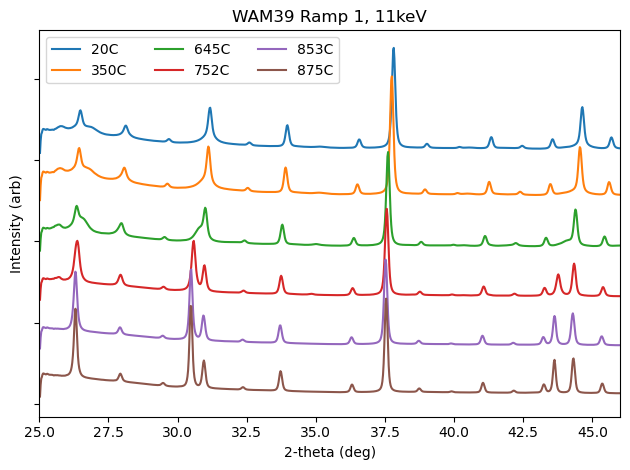

In [24]:
fig, ax = plt.subplots()
plot_indices = (0, 10,20,24,28,32)
offset_per = -30000
title = "WAM39 Ramp 1, 11keV"

for i, idx in enumerate(plot_indices):
    temp = output_data[idx][0]
    spectrum = output_data[idx][1]
    ax.plot(spectrum[0], spectrum[1] + offset_per * i, label=f'{temp:.0f}C')

plt.title(title)
plt.xlabel("2-theta (deg)")
plt.ylabel("Intensity (arb)")
ax.set(yticklabels = [])
plt.xlim((25, 46))
plt.legend(ncol=3, loc='upper left')
plt.tight_layout()
# plt.savefig('Output/' + title, dpi=300)
plt.show()

# Spectrogram
Maria suggested we plot the XRD over time as a spectrogram.

In [48]:
temperatures = []
intensities = []
times = []

for T, data, t in output_data:
    temperatures.append(T)
    intensities.append(data[1])
    times.append(t)

firsttime = min(times)
times = [(t - firsttime) // 60 for t in times]

twothetas = output_data[0][1][0]
left = np.min(twothetas)
right = np.max(twothetas)
bottom = np.min(temperatures)
top = np.max(temperatures)

intensities = np.array(intensities)

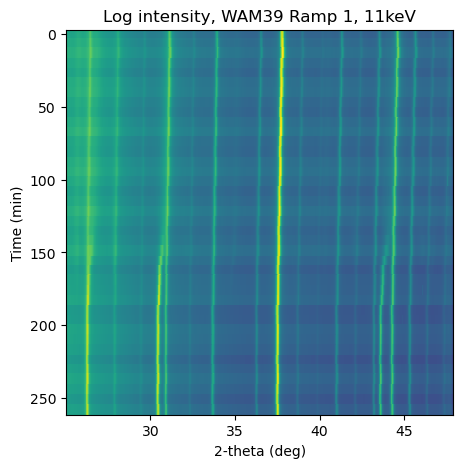

In [51]:
fig, ax = plt.subplots(figsize=(5,5))
plt.title("Log intensity, WAM39 Ramp 1, 11keV")
ax.set_xlabel("2-theta (deg)")
ax.set_ylabel("Time (min)")
ax.pcolor(twothetas, times, np.log(intensities))
plt.gca().invert_yaxis()
# ax2 = ax.secondary_yaxis(1.2, functions=(time_to_temp, temp_to_time))
# ax2.set_ylabel("Temperature (C)")

# plt.tight_layout()
# plt.savefig("Output/WAM39 Ramp 1 11keV Spectrogram", dpi=300)

## misc. plots

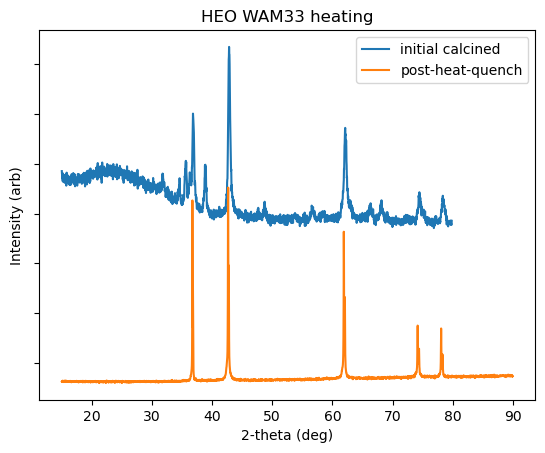

In [11]:
root2 = r'C:\Users\jade2\Dropbox (Personal)\Jade_CNRS_Internship\Data\PXRD_reference patterns'
files = ['WAM33_450degC.csv', 'WAM33_quenched.csv'] # 
temps = ['initial calcined', 'post-heat-quench'] #
scalings = [1, 0.2]

fig, ax = plt.subplots()

for i, f in enumerate(files):
    arr = np.genfromtxt(os.path.join(root2, f), delimiter=',').transpose()
    ax.plot(arr[0], scalings[i]*arr[1] - i*5, label=temps[i])
ax.legend()
ax.set_title('HEO WAM33 heating')
ax.set_xlabel('2-theta (deg)')
ax.set_ylabel('Intensity (arb)')
ax.set(yticklabels = [])

plt.savefig('Output/XRD-demo', dpi=300)
plt.show()